# Metabolomics

In [1]:
import pandas as pd
import numpy as np
from utils.utils import confidence_ellipse , save_fna

#Qiime
import qiime2 as q2
from qiime2.plugins.diversity.actions import alpha
from qiime2.plugins.feature_table.actions import rarefy
from qiime2.plugins.deicode.actions import rpca
from qiime2.plugins.gemelli.actions import ctf
from qiime2.plugins.diversity.actions import beta
from biom import Table, load_table

#Stats
from scipy.stats import sem
from skbio import OrdinationResults
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests

#Plotting
import plotnine as pn
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
%matplotlib inline

# Import data

In [2]:
#Data
root_dir="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/"
bt = load_table(root_dir + "intermediate_data/20200611_filtered_metabolmics_table.biom")
#Make into cpm
bt.transform(lambda x,y,z: x*1000000)

#Metadata
md=pd.read_csv(root_dir + "intermediate_data/20200611_filtered_metabolomics_metadata.tsv", sep='\t', index_col=0)
doty_samples = set( md.query('qiita_study_id==11712').index )
swell_samples = set( md.query('qiita_study_id==11713').index )

#Spit by chorot
doty_bt = bt.filter(doty_samples, inplace=False)
swell_bt = bt.filter(swell_samples, inplace=False)

#Convert to qiime2
doty_qza = q2.Artifact.import_data('FeatureTable[Frequency]', doty_bt)
swell_qza = q2.Artifact.import_data('FeatureTable[Frequency]', swell_bt)

___

# Beta diversity

Calculate beta diversity

In [ ]:
qza_bplts = {}
qza_dms = {}
dms = {}
biplots = {}

for study,qza in zip(["doty","stillwell"], [doty_qza, swell_qza]):
    #Calculate Deicode distances
    qza_bplts[study], qza_dms[study] = rpca(table = qza, n_components=3, min_feature_count=500, min_sample_count=0)
    #Convert from qza
    dms[study] = qza_dms[study].view(DistanceMatrix).to_data_frame()
    biplots[study] = qza_bplts[study].view(OrdinationResults)
    #Save
    qza_dms[study].save(root_dir + "intermediate_data/20200608_{}_metabolomics_deicode_dm.qza".format(study))
    qza_bplts[study].save(root_dir + "intermediate_data/20200608_{}_metabolomics_deicode_biplot.qza".format(study))

Load precalculated dm and biplots

In [3]:
qza_bplts = {}
qza_dms = {}
dms = {}
biplots = {}

for study in ["doty","stillwell"]:
    qza_dms[study] = q2.Artifact.load(root_dir + "intermediate_data/20200608_{}_metabolomics_deicode_dm.qza".format(study))
    qza_bplts[study] = q2.Artifact.load(root_dir + "intermediate_data/20200608_{}_metabolomics_deicode_biplot.qza".format(study))
    dms[study] = qza_dms[study].view(DistanceMatrix).to_data_frame()
    biplots[study] = qza_bplts[study].view(OrdinationResults)

Plot ordination

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/sw_notebooks/utils/utils.py:49: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(x, y)


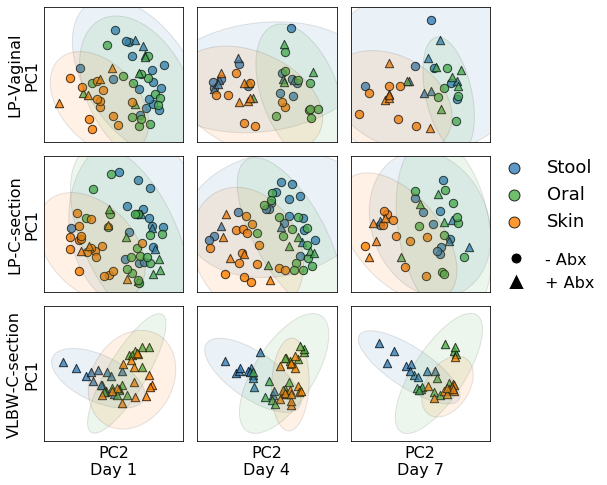

In [16]:
variance_dict = {}
points_dict = {}
for study in ["doty","stillwell"]:
    ordinaiton_samples = biplots[study].samples
    ordinaiton_samples.columns = ["Axis1","Axis2","Axis3"]
    ordination_variances = biplots[study].proportion_explained
    ordinaiton_samples = ordinaiton_samples.merge(md, right_index=True, left_index=True)
    points_dict[study] = ordinaiton_samples
    plot_variances = {"PC1":round(ordination_variances[0]*100,1),"PC2":round(ordination_variances[1]*100,1)}
    variance_dict[study]=plot_variances
    
days = [1,4,7]
cohorts = ["LP-Vaginal","LP-C-section","VLBW-C-section"]
sample_types = ["Stool","Oral","Skin"]
colors=['#377eb8',  '#4daf4a','#ff7f00',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
color_dict = {x:y for x,y in zip(sample_types,colors)}
abx_list = [0,1]
shape_list = ["o","^"]

fig, axs = plt.subplots(3,3, sharex=False, sharey=False, figsize=(8,8))
fig.subplots_adjust(wspace=0.1, hspace=.1)
for i in range(len(cohorts)):
    if i==2:
        ordinaiton_samples = points_dict["stillwell"]
    else:
        ordinaiton_samples = points_dict["doty"]
    for j in range(len(days)):
        for C in sample_types:
            for ab in range(len(abx_list)):
                #data_subset = ordinaiton_samples.loc[ (deicode_ord["study_delivery_mode"] == cohorts[i]) & (deicode_ord["age"] == days[j]) & (deicode_ord["sample_type"] == C) & (deicode_ord.abx_any_source == abx_list[ab])]
                data_subset = ordinaiton_samples.query('study_delivery_mode==@cohorts[@i] & age==@days[@j] & sample_type==@C & metadata_abx==@abx_list[@ab]')
                x= data_subset.Axis1
                y= data_subset.Axis2
                if i==2:
                    confidence_ellipse(x,y,axs[i,j],facecolor=color_dict[C], alpha=.1,edgecolor= "black"  )
                if ab==0:
                    confidence_ellipse(x,y,axs[i,j],facecolor=color_dict[C], alpha=.1,edgecolor= "black"  )
                    axs[i,j].scatter(x, y, s=70, alpha=.8, c = color_dict[C], marker = shape_list[ab], label=C, edgecolors="black", linewidth=1)
                else:
                    axs[i,j].scatter(x, y, s=70, alpha=.8, c = color_dict[C], marker = shape_list[ab], label=None, edgecolors="black", linewidth=1)
                
        if i!=2:
            axs[i,j].set_ylim([-.080,.110])
            axs[i,j].set_xlim([-.090,.080])
        if i == 2 :
            axs[i,j].set_xlabel("PC2\nDay " + str(days[j]) , size=16)
        if j==0:
            axs[i,j].set_ylabel(cohorts[i] + "\nPC1", size=16)
        #remove axis text and ticks
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticklabels([])
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        
#Abx legend
point = Line2D([0], [0], marker='.', color='w', label='Scatter', markerfacecolor='black', markersize=22)
star = Line2D([0], [0], marker='^', color='w', label='Scatter', markerfacecolor='black', markersize=16)
leg1 = plt.legend([point,star],['- Abx','+ Abx'], bbox_to_anchor=(1.85, 1.5), loc='upper right', ncol=1,fontsize=14,frameon=False,prop={'size': 16})
lgd =plt.legend(loc='upper right',bbox_to_anchor=[1.85, 2.2], ncol=1, fontsize=14,frameon=False,prop={'size': 18})
for handle in lgd.legendHandles:
    handle.set_sizes([120]) 
plt.gca().add_artist(leg1) 

fig.savefig(root_dir + 'results/figures/svg/20200608_metabolomics_deicode_pcoa_grid.svg', bbox_extra_artists=(lgd,), 
            bbox_inches='tight',pad_inches = 1, format="svg", dpi=300)
fig.savefig(root_dir + 'results/figures/20200608_metabolomics_deicode_pcoa_grid.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)
plt.show()

In [15]:
variance_dict

{'doty': {'PC1': 54.5, 'PC2': 30.6}, 'stillwell': {'PC1': 70.3, 'PC2': 25.1}}

___

# Permanovas over time

In [15]:
md.groupby("study_delivery_mode").maternal_any_abx.value_counts()

study_delivery_mode  maternal_any_abx
LPI-C-section        1.0                 349
LPI-Vaginal          0.0                 166
                     1.0                 136
VLBW-C-section       0.0                 264
Name: maternal_any_abx, dtype: int64

In [32]:
def make_maternal_abx_012(x):
    '''0: no abx
        1:abx+
        2:abx-/mabx+
    '''
    if not x.metadata_abx:
        if x.maternal_any_abx:
            return(2)
        else:
            return(0)
    else:
        return(1)
    
md["abx012"] = md.apply(axis=1, func=make_maternal_abx_012)

In [33]:
md.groupby("study_delivery_mode").abx012.value_counts()

study_delivery_mode  abx012
LPI-C-section        2         335
                     1          86
LPI-Vaginal          2         127
                     0         119
                     1         107
VLBW-C-section       1         306
Name: abx012, dtype: int64

In [8]:
cohorts = ["LP-Vaginal","LP-C-section","VLBW-C-section"]
days = set(md.age)

out_list = []
for cohort in cohorts:
    if cohort =="VLBW-C-section":
        dm_df = dms["stillwell"]
    else:
        dm_df = dms["doty"]
    for abx in [0.0, 1.0]:
        if cohort=="VLBW-C-section" and abx == 0.0:
            continue
        for day in days:
            #Filter metadata
            md_ss = md.query('study_delivery_mode==@cohort & metadata_abx==@abx & age==@day')          
            ss_samples = set(md_ss.index)
            #Filter distance matrix
            dm_df_ss = dm_df.loc[[x in ss_samples for x in dm_df.index], [x in ss_samples for x in dm_df.columns]]
            #If any of the sample types has less than 3 samples, skip
            if any(md_ss.sample_type.value_counts() < 3) or not len(dm_df_ss):
                print("Skipping Cohort:{}, abx:{}, day:{}".format(cohort,abx,day))
                continue
            temp_dm=DistanceMatrix(dm_df_ss, ids=dm_df_ss.index)
            pm = permanova(distance_matrix=temp_dm, grouping=md_ss, column="sample_type")
            pm_df = pd.DataFrame(pm).transpose()
            pm_df["cohort"] = cohort
            pm_df["abx"] = abx
            pm_df["day"] = day
            out_list.append(pm_df)
perm_df = pd.concat(out_list)
#Add sgnificance bool
perm_df["sig"] = [x < 0.05 for x in perm_df["p-value"]]
perm_df["sig"] = ["p<0.05" if x==True else "p>0.05" for x in perm_df.sig]

#save permanova
#perm_df.to_csv(root_dir + "/results/tables/metabolomics_permanova_over_time.tsv",sep='\t')

Skipping Cohort:LP-Vaginal, abx:1.0, day:0.0
Skipping Cohort:LP-C-section, abx:1.0, day:0.0


Plot Permanovas

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 2.5 x 5.5 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/svg/20200608_metabolomics_deicode_permF_over_time.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 2.5 x 5.5 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/20200608_metabolomics_deicode_permF_over_time.p

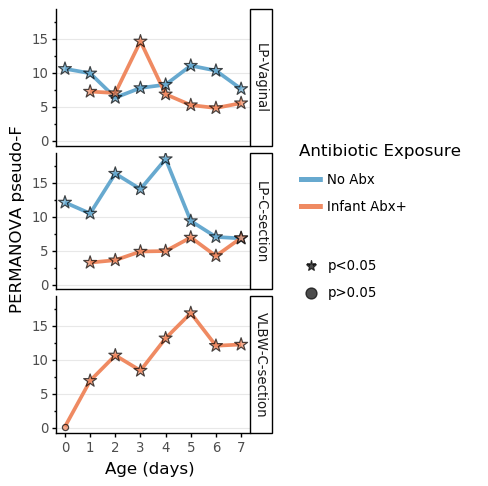

<ggplot: (8762748772784)>

In [22]:
pn.options.figure_size = (2.5,5.5)

plot_dat = perm_df.copy()
plot_dat["cohort"] = pd.Categorical(plot_dat.cohort, ordered=True, categories=cohorts)
plot_dat["value"] = [float(x) for x in plot_dat["test statistic"]]
abx_dict = {0.0: "No Abx",
           1.0: "Infant Abx+"}
plot_dat["abx"] = pd.Categorical([abx_dict[x] for x in plot_dat["abx"]], categories=["No Abx","Infant Abx+"])

p = (pn.ggplot(data=plot_dat) +
    pn.geom_line( pn.aes( x="day", y="value", color="abx"), size=1.5) +
    pn.geom_point( pn.aes( x="day", y="value", fill="abx", shape="sig", size="sig"), alpha=.7) +
     pn.scale_size_manual([5,2]) +
     pn.scale_fill_manual(["#67a9cf","#ef8a62", "green"]) +
     pn.scale_color_manual(["#67a9cf","#ef8a62","green"]) +
     pn.scale_shape_manual( values=["*","o"]) +
     pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7]) +
     pn.facet_grid('cohort~.') +
     pn.guides( color=pn.guide_legend(override_aes={"size":2}),
               size=None,
              fill =None,
              shape = pn.guide_legend(override_aes={"size":4})) +
     pn.labs(x="Age (days)", y="PERMANOVA pseudo-F", color="Antibiotic Exposure\n", shape="") +
    pn.theme_classic(base_size=12) +
     pn.theme(panel_grid_major_y = pn.element_line(color="lightgrey",alpha=.5),
             axis_ticks_minor_x = pn.element_blank())
    )
p.save(root_dir + "results/figures/svg/20200608_metabolomics_deicode_permF_over_time.svg", dpi=300)
p.save(root_dir + "results/figures/20200608_metabolomics_deicode_permF_over_time.pdf", dpi=300)
p

___

# Individual metabolite abundances
Doty only

Import data

In [134]:
#BM metadata
bm_md = pd.read_csv(root_dir + "/metadata/20200604_doty_bm_metadata.tsv", sep='\t', index_col=0)

#Files from Julia's MS2 co-analysis
stody_bm_file = root_dir + "raw_data/metabolomics_ms2/METABOLOMICS-SNETS-V2-ec46dc69-view_all_clusters_withID_beta-main.tsv"
bm_formula_file = root_dir + "raw_data/metabolomics_ms2/METABOLOMICS-SNETS-V2-f19d5ba5-view_all_clusters_withID_beta-main.tsv"
stody_bm_file2 = root_dir + "raw_data/metabolomics_ms2/METABOLOMICS-SNETS-V2-ec46dc69-view_compound_occurrence-main.tsv"

#Import to df
stody_bm_raw_df = pd.read_csv(stody_bm_file, sep='\t')
bm_formula_raw_df = pd.read_csv(bm_formula_file, sep='\t')
stody_bm_raw_df2 = pd.read_csv(stody_bm_file2, sep='\t')

Make presence absence matrix

In [135]:
max_clurster_index = stody_bm_raw_df["cluster index"].max() + 1
all_samples = [x for x in stody_bm_raw_df2.columns if "mzXML" in x]
out_dict = {x:np.zeros(max_clurster_index, np.int) for x in all_samples} 
for i,row in stody_bm_raw_df.iterrows():
    samples = row.UniqueFileSources.split("|")
    for s in samples:
        out_dict[s][row["cluster index"]] = 1
pres_abs_matrix = pd.DataFrame(out_dict)
pres_abs_matrix.columns = [x.replace(".mzXML","") for x in pres_abs_matrix.columns]
pres_abs_matrix.index.name= "cluster_index"

#Remove balnk rows
pres_abs_matrix = pres_abs_matrix.loc[pres_abs_matrix.sum(axis=1) > 0]


#Convert to biom and qza
pres_abs_bt = Table(data = pres_abs_matrix.to_numpy(),
      observation_ids = [str(x) for x in pres_abs_matrix.index],
     sample_ids = pres_abs_matrix.columns,
          type="Metabolite table")
pres_abs_qza = q2.Artifact.import_data('FeatureTable[Frequency]', pres_abs_bt)

#Save presence absence matrix
pres_abs_matrix.to_csv(root_dir + "intermediate_data/20200608_doty_bm_pres_abs_matrix.tsv")
pres_abs_qza.save(root_dir + "intermediate_data/20200608_doty_bm_pres_abs_matrix.qza")

Plotting funcitons

In [143]:
def make_df(compound_list, body_site, age_col="age", ):
    id_list = [x[0] for x in compound_list]
    name_list = [x[1] for x in compound_list]
    md_subset = md.query('sample_type==@body_site')
    temp_df = pd.DataFrame(pres_abs_matrix.loc[id_list]).transpose().merge(md_subset, right_index=True, left_index=True, how="inner")
    temp_df.rename(columns={x[0]:x[1] for x in compound_list}, inplace=True)
    agg_dict = {x:sum for x in name_list}
    agg_dict["abx"] = "count"
    temp_df = temp_df.groupby(age_col).agg(agg_dict).reset_index()
    temp_df.rename(columns={"abx":"n"}, inplace=True)
    temp_df = temp_df.loc[:,name_list + ["n", age_col]]
    temp_df = temp_df.loc[[x not in ["not_collected","not applicable"] for x in temp_df[age_col]]]
    temp_df[age_col] = [float(x) for x in temp_df[age_col]]            
    temp_df = temp_df.melt(id_vars=["n", age_col])
    temp_df["pct"] = temp_df.apply(axis=1, func=lambda x: x.value/x.n)
    temp_df["n_label"] = ["n:" + str(x) for x in temp_df.n]
    return(temp_df)
def make_plot(df, xmin, xmax, agecol = "age", xlab='Age', t=''):
    p= (pn.ggplot(data = df) +
    pn.geom_line( pn.aes( x= agecol, y="pct", group="variable", color="variable"), size=3) +
    pn.geom_point( pn.aes( x= agecol, y="pct", group = "variable"), size=3) +
    pn.geom_text( pn.aes( x= agecol, y=1.1, label="n_label" ), size=8) +
    pn.scale_x_continuous(limits=[xmin,xmax], breaks = range(xmin,xmax+1)) + 
    pn.scale_y_continuous(limits=[0,1.1], breaks=[0,.2,.4,.6,.8,1]) +
    pn.labs(x=xlab, y="Portion Infants with\nCompound Detected", color="Metabolite", title=t) +
    pn.theme(
        panel_background = pn.element_rect(color="black", fill="white"),
        panel_border = pn.element_rect(color="black", fill=None, size=2),
        panel_grid_minor = pn.element_blank(),
        panel_grid_major = pn.element_line(color="grey", alpha=.3),
        legend_key = pn.element_rect(fill="white"),
        axis_text = pn.element_text(size=12, color="black"),
        axis_title = pn.element_text(size=12)
        
    )
       )
        
    return(p)

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 4 x 3 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/individual_mets_stool.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


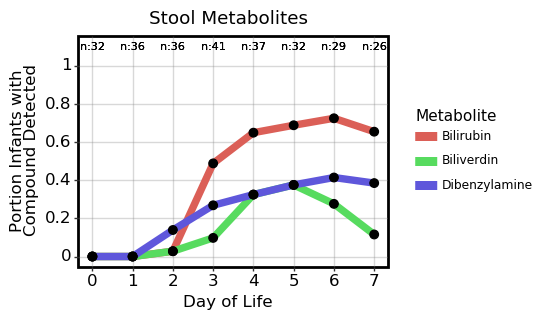

<ggplot: (-9223363264127781053)>

In [163]:
pn.options.figure_size = (4,3)
compound_list = [(160903,"Bilirubin"),
                (160614,"Biliverdin"),
                (499,'Dibenzylamine')]
a = make_df(compound_list, "Stool","age")
p =make_plot(a,0,7, agecol= "age", xlab="Day of Life",t="Stool Metabolites")
p.save(root_dir + "results/figures/individual_mets_stool.pdf", dpi=300)
p

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 4 x 3 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/individual_mets_stool_HMO.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


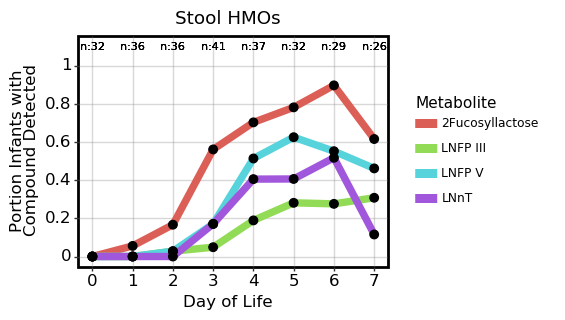

<ggplot: (8772738932046)>

In [166]:
hmos = [(151117,"2Fucosyllactose"), (127945,"LNFP V"), (174664,"LNnT"),(179656,"LNFP III")]
hmo_df = make_df(hmos, "Stool","age")
p = make_plot(hmo_df,0,7,agecol= "age", xlab="Day of Life",t="Stool HMOs")

p.save(root_dir + "results/figures/individual_mets_stool_HMO.pdf", dpi=300)
p

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 4 x 3 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/individual_mets_oral.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


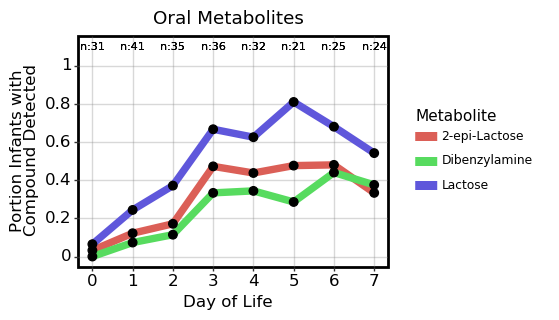

<ggplot: (-9223363264129074940)>

In [167]:
oral_mets = [(173486,'2-epi-Lactose'),
            (77332,'Lactose'),
            (499,'Dibenzylamine')]
oral_df = make_df(oral_mets, "Oral","age")
p = make_plot(oral_df,0,7, agecol= "age", xlab="Day of Life",t="Oral Metabolites")

p.save(root_dir + "results/figures/individual_mets_oral.pdf", dpi=300)
p

# Jaccard

Import presence absence qza

In [76]:
pres_abs_qza = q2.Artifact.load(root_dir + "intermediate_data/20200608_doty_bm_pres_abs_matrix.qza")

jaccard_dm = beta(table = pres_abs_qza, metric="jaccard").distance_matrix
jaccard_dm_df = jaccard_dm.view(DistanceMatrix).to_data_frame()


/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Get Jaccard distances from breastmilk

In [196]:
prefeed_samples = set(md.query('bm_yet == "0"').index)
postfeed_samples = set(md.query('bm_yet == "1"').index)
bm_samples = set(bm_md.query('sample_type in ["Mother Breast Milk","Donor Breast Milk"]').index)

stool_samples = set(md.query('sample_type == "Stool"').index)
oral_samples = set(md.query('sample_type == "Oral"').index)
skin_samples = set(md.query('sample_type == "Skin"').index)

abx_samples = set(md.query('abx_any_source == "1"').index)
nbx_samples = set(md.query('abx_any_source == "0"').index)

out_list = []

for body_site, name in zip([stool_samples, oral_samples,skin_samples],["Stool","Oral","Skin"]):
    for abx_name,abx in zip(["Abx+","Abx-"],[abx_samples,nbx_samples]):
        pre_samples = body_site.intersection(prefeed_samples & abx)
        post_samples = body_site.intersection(postfeed_samples & abx)
        jaccard_pre_ss = jaccard_dm_df.loc[[x in bm_samples for x in jaccard_dm_df.index], [x in pre_samples for x in jaccard_dm_df.columns]]
        jaccard_post_ss = jaccard_dm_df.loc[[x in bm_samples for x in jaccard_dm_df.index], [x in post_samples for x in jaccard_dm_df.columns]]
        for value in jaccard_pre_ss.apply(axis=0, func=np.mean):
            out_list.append([name, "Pre-Breastmilk", value, abx_name])
        for value in jaccard_post_ss.apply(axis=0, func=np.mean):
            out_list.append([name, "Post-Breastmilk", value, abx_name])

    
#Make DataFrame   
out_df = pd.DataFrame(out_list)
out_df.columns = ["sample_type","prepost","value", "abx"]
out_df["prepost"] = pd.Categorical(out_df["prepost"],categories=["Pre-Breastmilk","Post-Breastmilk"])
    

Plot

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Oral_Pre-Breastmilk v.s. Oral_Post-Breastmilk: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.303e-08 U_stat=1.007e+04
Stool_Pre-Breastmilk v.s. Stool_Post-Breastmilk: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.861e-22 U_stat=1.492e+04
Skin_Pre-Breastmilk v.s. Skin_Post-Breastmilk: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.220e-01 U_stat=5.875e+03


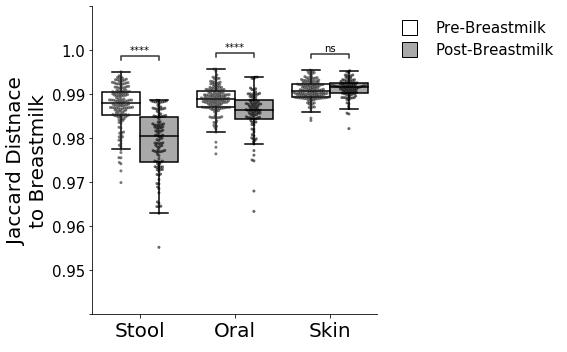

In [450]:
fig,axs =  plt.subplots(1,1, figsize=(8,5), sharex=True, sharey=True)

#Add plot elements
df = out_df.copy()
#Boxplot
sns.boxplot(data=df, x="sample_type", y="value",
                ax=axs, color="white",fliersize=0, hue="prepost", palette=["white","darkgrey"])
#Points
sns.swarmplot( data=df, x="sample_type",hue="prepost", y="value", ax=axs, size=3, dodge=True, color="black", alpha=.6)
#Statistics bars
add_stat_annotation(axs, data=df, x="sample_type", y="value",hue="prepost",
                    perform_stat_test=True,
                    test='Mann-Whitney',
                    box_pairs=[(("Stool","Pre-Breastmilk"),("Stool","Post-Breastmilk")),
                              (("Oral","Pre-Breastmilk"),("Oral","Post-Breastmilk")),
                              (("Skin","Pre-Breastmilk"),("Skin","Post-Breastmilk"))],
                    comparisons_correction='bonferroni',
                    text_format='star', loc='inside', verbose=1)



#Format boxplot look
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
for k,box in enumerate(axs.artists):
    box.set_edgecolor('black')
    #box.set_facecolor('white')

    for u in range(6*k,6*(k+1)):
         axs.lines[u].set_color('black')

#Format axes
axs.set_ylim(0.94,1.01)
axs.tick_params(axis = 'y', which = 'major', labelsize = 15)
axs.tick_params(axis = 'x', which = 'major', labelsize = 20)
axs.set_ylabel('Jaccard Distnace\nto Breastmilk', fontsize=20)
axs.set_xlabel(' ', fontsize=1)
axs.set_yticklabels(["",.95,.96,.97,.98,.99,1.0,''])

#Make legend
custom_lines = [Line2D([0], [0], color="white", markeredgecolor="black",markeredgewidth=1, marker="s", markersize=15),
                Line2D([0], [0], color="darkgrey",lw=0, markeredgecolor="black",markeredgewidth=1, marker="s", markersize=15)]
legend = axs.legend()
legend.remove()           
lgd = plt.legend(custom_lines, ["Pre-Breastmilk","Post-Breastmilk"],bbox_to_anchor=(1.01, 1), loc='upper left', prop={'size': 15})
lgd.get_frame().set_linewidth(0.0)

fig.tight_layout()
#Save figure
fig.savefig(root_dir + "results/figures/20200608_metabolomics_jaccard_boxplot.pdf", dpi=300)


# Permanovas

Effect of antibiotics (only LPI)

In [27]:
out_list = []
dm_df = dms["doty"]

for cohort in ["LPI-Vaginal","LPI-C-section"]:
    for sample_type in ["Stool","Oral","Skin"]:
        temp_md = md.query('study_delivery_mode==@cohort & sample_type==@sample_type').copy()
        sample_ss= set(temp_md.index)
        #Drop NAs
        dm_df_ss = dm_df.loc[sample_ss,sample_ss]
        if any(temp_md.abx_any_source.value_counts() < 20) or not len(dm_df_ss):
            print(cohort, sample_type)
            continue
        temp_dm=DistanceMatrix(dm_df_ss, ids=dm_df_ss.index)
        pm = permanova(distance_matrix=temp_dm, grouping=temp_md, column="metadata_abx")
        pm["Cohort"] = cohort
        pm["Test factor"] = "Antibiotics"
        pm["sample_type"] = sample_type
        pm_df = pd.DataFrame(pm).transpose()
        out_list.append(pm_df)

In [28]:
abx_perm_df = pd.concat(out_list)
abx_perm_df = abx_perm_df.loc[:,["method name","Test factor","Cohort","sample_type", "number of groups","test statistic","p-value"]]
abx_perm_df.columns= ["method name","Test factor","Cohort","sample_type", "number of groups","pseudo-F","p-value"]
#abx_perm_df["BH p-value"] = multipletests(abx_perm_df["p-value"], method="bonferroni")[1]
abx_perm_df.to_csv(root_dir + "results/tables/20200609_metabolomics_premanova_abx.tsv",sep='\t')
abx_perm_df

,method name,Test factor,Cohort,sample_type,number of groups,pseudo-F,p-value
PERMANOVA results,PERMANOVA,Antibiotics,LPI-Vaginal,Stool,2,0.488232,0.608
PERMANOVA results,PERMANOVA,Antibiotics,LPI-Vaginal,Oral,2,6.86676,0.002
PERMANOVA results,PERMANOVA,Antibiotics,LPI-Vaginal,Skin,2,7.05322,0.006
PERMANOVA results,PERMANOVA,Antibiotics,LPI-C-section,Stool,2,2.96652,0.036
PERMANOVA results,PERMANOVA,Antibiotics,LPI-C-section,Oral,2,0.798096,0.425
PERMANOVA results,PERMANOVA,Antibiotics,LPI-C-section,Skin,2,1.21822,0.275


Effect of delivery mode (LPI only)

In [25]:
out_list = []

dm_df = dms["doty"]

for sample_type in ["Stool","Oral","Skin"]:
    for abx in [1,0]:
        temp_md = md.query('qiita_study_id==11712 & sample_type==@sample_type & metadata_abx == @abx').copy()
        sample_ss= set(temp_md.index)
        #Drop NAs
        dm_df_ss = dm_df.loc[sample_ss,sample_ss]
        if any(temp_md.delivery_mode.value_counts() < 10) or not len(dm_df_ss):
            print(sample_type,abx)
            continue
        temp_dm=DistanceMatrix(dm_df_ss, ids=dm_df_ss.index)
        pm = permanova(distance_matrix=temp_dm, grouping=temp_md, column="delivery_mode")
        pm["birth weight"] = "LPI"
        pm["Test factor"] = "delivery mode"
        pm["abx"] = abx
        pm["sample_type"] = sample_type
        pm_df = pd.DataFrame(pm).transpose()
        out_list.append(pm_df)

In [26]:
delivery_mode_perm_df = pd.concat(out_list)
delivery_mode_perm_df = delivery_mode_perm_df.loc[:,["method name","Test factor","birth weight","sample_type","abx", "number of groups","test statistic","p-value"]]
delivery_mode_perm_df.columns= ["method name","Test factor","birth weight","sample_type","abx", "number of groups","pseudo-F","p-value"]
#delivery_mode_perm_df["BH p-value"] = multipletests(delivery_mode_perm_df["p-value"], method="bonferroni")[1]
delivery_mode_perm_df.to_csv(root_dir + "results/tables/20200609_metabolomics_premanova_delivery_mode.tsv",sep='\t')
delivery_mode_perm_df

,method name,Test factor,birth weight,sample_type,abx,number of groups,pseudo-F,p-value
PERMANOVA results,PERMANOVA,delivery mode,LPI,Stool,1,2,4.58254,0.008
PERMANOVA results,PERMANOVA,delivery mode,LPI,Stool,0,2,0.0384098,0.978
PERMANOVA results,PERMANOVA,delivery mode,LPI,Oral,1,2,9.53723,0.002
PERMANOVA results,PERMANOVA,delivery mode,LPI,Oral,0,2,0.164147,0.806
PERMANOVA results,PERMANOVA,delivery mode,LPI,Skin,1,2,4.59657,0.016
PERMANOVA results,PERMANOVA,delivery mode,LPI,Skin,0,2,3.0614,0.063


___

# Stepwise RDA
- Running RDA on deicode distances. Too much data to run on raw data
- Only Doty

Format data

In [4]:
root_dir="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/"

In [14]:
sample_ss

['11712.SUBJECT1.STOOL.21',
 '11712.SUBJECT1.STOOL.22',
 '11712.SUBJECT1.STOOL.23',
 '11712.SUBJECT1.STOOL.24',
 '11712.SUBJECT1.STOOL.26',
 '11712.SUBJECT10.STOOL.46',
 '11712.SUBJECT10.STOOL.47',
 '11712.SUBJECT10.STOOL.48',
 '11712.SUBJECT10.STOOL.50',
 '11712.SUBJECT10.STOOL.51',
 '11712.SUBJECT10.STOOL.52',
 '11712.SUBJECT11.STOOL.61',
 '11712.SUBJECT11.STOOL.62',
 '11712.SUBJECT11.STOOL.63',
 '11712.SUBJECT12.STOOL.100',
 '11712.SUBJECT12.STOOL.94',
 '11712.SUBJECT12.STOOL.95',
 '11712.SUBJECT12.STOOL.96',
 '11712.SUBJECT12.STOOL.97',
 '11712.SUBJECT12.STOOL.98',
 '11712.SUBJECT12.STOOL.99',
 '11712.SUBJECT13.STOOL.114',
 '11712.SUBJECT13.STOOL.115',
 '11712.SUBJECT13.STOOL.116',
 '11712.SUBJECT14.STOOL.1228',
 '11712.SUBJECT14.STOOL.136',
 '11712.SUBJECT14.STOOL.138',
 '11712.SUBJECT14.STOOL.139',
 '11712.SUBJECT14.STOOL.140',
 '11712.SUBJECT14.STOOL.141',
 '11712.SUBJECT14.STOOL.142',
 '11712.SUBJECT15.STOOL.151',
 '11712.SUBJECT15.STOOL.152',
 '11712.SUBJECT16.STOOL.188',
 '11

In [82]:
jaccard_dm = beta(table = doty_qza, metric="jaccard").distance_matrix
jaccard_dm_df = jaccard_dm.view(DistanceMatrix).to_data_frame()

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [84]:
doty_md

NameError: name 'doty_md' is not defined

RDA with features over 1%

In [58]:
ordination

NameError: name 'ordination' is not defined

In [85]:
!mkdir -p $root_dir/intermediate_data/ordistep
###DEICODE DM
#Subset distance matrix (all body sites)
#dm_df = dms["doty"]

##RAW DATA
#features_over_1pct = doty_bt.ids("observation")[doty_bt.sum('observation') > 10000]
#doty_bt_filt = doty_bt.filter(features_over_1pct, axis="observation", inplace=False)
#doty_df_filt = doty_bt_filt.to_dataframe().transpose()


##ORDINATION
#doty_ordination = biplots["doty"].samples
#doty_ordination.columns = ["Axis1","Axis2","Axis3"]
#doty_df_filt = doty_ordination.copy()
doty_df_filt = jaccard_dm_df.copy()

dm_df_samples = set(doty_df_filt.index)
dm_df= doty_df_filt.sort_index()
dm_df.index.name="X.SampleID"
dm_df.to_csv(root_dir + "intermediate_data/ordistep/rda_deicode_metabolomics_data_all.tsv",sep='\t')

#Subset metadata (all body sites)
rda_md = md.query('index in @dm_df_samples').loc[:,["host_subject_id","metadata_abx","delivery_mode","qiita_study_id","age","sample_type","randomization"]]
rda_md.index.name="X.SampleID"
rda_md = rda_md.sort_index()
rda_md.to_csv(root_dir + "intermediate_data/ordistep/rda_metabolomics_md_all.tsv",sep='\t')

assert(all([x==y for x,y in zip(rda_md.index,dm_df.index )]))

#Subset by body site
for sample_type in ["Stool","Oral","Skin"]:
    rda_md_ss = rda_md.query('sample_type==@sample_type')
    rda_md_ss = rda_md_ss.drop(columns=["sample_type"])
    rda_md_ss.to_csv(root_dir + "/intermediate_data/ordistep/rda_metabolomics_md_{}.tsv".format(sample_type), sep='\t')
    sample_ss = list(rda_md_ss.index)
    dm_df_ss = dm_df.loc[sample_ss,sample_ss]
    dm_df_ss.to_csv(root_dir + "intermediate_data/ordistep/rda_deicode_metabolomics_data_{}.tsv".format(sample_type),sep='\t')
    assert(all([x==y for x,y in zip(rda_md_ss.index,dm_df_ss.index )]))

In [98]:
rda_md

,host_subject_id,metadata_abx,delivery_mode,qiita_study_id,age,sample_type,randomization
X.SampleID,,,,,,,
11712.SUBJECT1.ORAL.1,11712-1,0.0,c-section,11712,1.0,Oral,Formula
11712.SUBJECT1.ORAL.2,11712-1,0.0,c-section,11712,2.0,Oral,Formula
11712.SUBJECT1.ORAL.3,11712-1,0.0,c-section,11712,3.0,Oral,Formula
11712.SUBJECT1.ORAL.4,11712-1,0.0,c-section,11712,4.0,Oral,Formula
11712.SUBJECT1.ORAL.6,11712-1,0.0,c-section,11712,6.0,Oral,Formula
...,...,...,...,...,...,...,...
11712.SUBJECT9.STOOL.1208,11712-9,1.0,vaginal,11712,3.0,Stool,Donor human milk
11712.SUBJECT9.STOOL.1209,11712-9,1.0,vaginal,11712,4.0,Stool,Donor human milk
11712.SUBJECT9.STOOL.1210,11712-9,1.0,vaginal,11712,5.0,Stool,Donor human milk


In [86]:
%%script bash 

source ~/.bash_profile
conda activate qiime2-2020.2

root_dir=/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/intermediate_data/ordistep
Rfile=/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/sw_notebooks/utils/stepwise-rda.R

declare -A datasets=( [all]=$root_dir/rda_deicode_metabolomics_data_all.tsv
                     [Stool]=$root_dir/rda_deicode_metabolomics_data_Stool.tsv
                     [Oral]=$root_dir/rda_deicode_metabolomics_data_Oral.tsv
                    [Skin]=$root_dir/rda_deicode_metabolomics_data_Skin.tsv )

declare -A metadatas=( [all]=$root_dir/rda_metabolomics_md_all.tsv
                     [Stool]=$root_dir/rda_metabolomics_md_Stool.tsv
                     [Oral]=$root_dir/rda_metabolomics_md_Oral.tsv
                    [Skin]=$root_dir/rda_metabolomics_md_Skin.tsv )


for subset in {all,Stool,Oral,Skin}
    do
    out_file=$root_dir/deicode_metabolomics_ordistep_results_${subset}.tsv
    Rscript $Rfile ${datasets[$subset]} ${metadatas[$subset]} $out_file
    done


R version 3.5.1 (2018-07-02) 
Call: rda(formula = Y_16S ~ 1, data = X_16S)

              Inertia Rank
Total           3.157     
Unconstrained   3.157  773
Inertia is variance 

Eigenvalues for unconstrained axes:
   PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8 
1.2099 0.6905 0.2134 0.1184 0.0625 0.0443 0.0398 0.0331 
(Showing 8 of 773 unconstrained eigenvalues)

Call: rda(formula = Y_16S ~ host_subject_id + metadata_abx +
delivery_mode + qiita_study_id + age + sample_type + randomization,
data = X_16S)

              Inertia Proportion Rank
Total          3.1573     1.0000     
Constrained    1.2602     0.3991   60
Unconstrained  1.8971     0.6009  713
Inertia is variance 
Some constraints were aliased because they were collinear (redundant)

Eigenvalues for constrained axes:
  RDA1   RDA2   RDA3   RDA4   RDA5   RDA6   RDA7   RDA8   RDA9  RDA10  RDA11 
0.6153 0.4032 0.0990 0.0394 0.0163 0.0097 0.0076 0.0062 0.0058 0.0042 0.0039 
 RDA12  RDA13  RDA14  RDA15  RDA16  RDA17  RDA1

Loading required package: permute
Loading required package: lattice
This is vegan 2.5-6
Loading required package: permute
Loading required package: lattice
This is vegan 2.5-6
Loading required package: permute
Loading required package: lattice
This is vegan 2.5-6
Loading required package: permute
Loading required package: lattice
This is vegan 2.5-6


Output tables are empty, nothing is significant

In [97]:
!cat $root_dir/intermediate_data/ordistep/deicode_metabolomics_ordistep_results_*

___

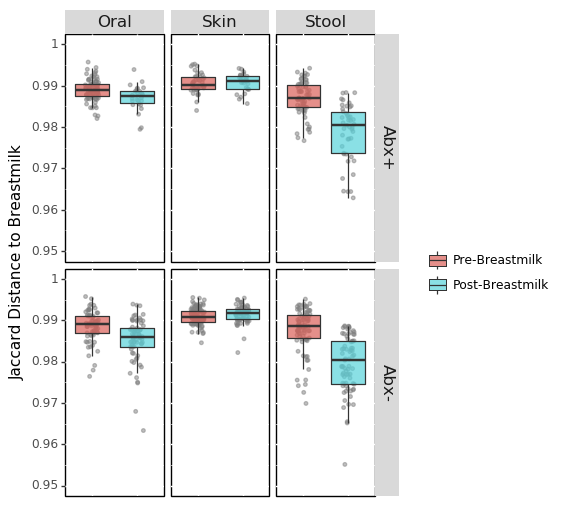

<ggplot: (-9223363264122148997)>

In [200]:
# Showing abx stratification doesn't matter
for sample_type in ["Stool","Oral","Skin"]:
    pre_values = out_df.query('sample_type== @sample_type & prepost=="Pre-Breastmilk"').value
    post_values = out_df.query('sample_type== @sample_type & prepost=="Post-Breastmilk"').value
    wilcox = ranksums(x=pre_values, y=post_values)
    print(wilcox)

pn.options.figure_size = (4, 6)
p = (pn.ggplot( data = out_df) +
     pn.geom_jitter( pn.aes(x='prepost', y='value' ), 
                   width=.15,size=1, alpha=.5, color="grey" ) +
     pn.geom_boxplot( pn.aes(x= "prepost",y= "value",fill="prepost"), 
                     outlier_alpha = 0, position="dodge2", size=.5, alpha=.7) +
     pn.facet_grid('abx~sample_type') +
     pn.scale_y_continuous(limits = [0.95,1]) +
     pn.labs(x='', y="Jaccard Distance to Breastmilk", fill="") +
     pn.guides(color=None) +
     pn.theme(
         panel_border = pn.element_rect(fill="white", color="black"),
         panel_background = pn.element_rect(fill="white", color="black"),
         axis_text_x = pn.element_blank(),
         strip_text = pn.element_text(size=12),
         axis_ticks_major_x = pn.element_blank(),
         legend_key = pn.element_rect(fill ="white", colour =None)
    
     )
        )
p